In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
data = pd.read_csv('data/samsung_data.txt',sep='|')

In [4]:
train = data.sample(frac=0.7,
                    random_state=42)

test = data[~data.index.isin(train.index)]

In [5]:
def varPlot(X,model,plotSize=(15,6),xticks=False, ntree=10):
    
    model_vars = pd.DataFrame(
         {'variable':X.columns,
          'importance':model.feature_importances_})

    model_vars.sort_values(by='importance',
                           ascending=False,
                           inplace=True)
    
    varImp = plt.figure(figsize=plotSize)
    #varImp = sns.set_style('whitegrid')
    
    varImp = sns.barplot(y='importance',
        x='variable',
        data=model_vars,
        palette=sns.color_palette("Blues_r",
                                  n_colors=X.shape[1]))
    
    if xticks==True:
        varImp = plt.xticks([])
    else:
        varImp = plt.xticks(rotation=90)
        
    varImp = plt.xlabel('Variable')
    varImp = plt.ylabel('Variable Importance')
    varImp = plt.title('Random Forest : Averaged variable importance over '+str(ntree)+' trees')
    return(varImp)

In [6]:
X = train[train.columns[:-2]]
Y = train.activity
randomState = 42
ntree = 25

model0 = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=True,
             oob_score=True)
model0 = model0.fit(X, Y)
model0.oob_score_

0.9650213758258842

Text(0.5,1,'Random Forest : Averaged variable importance over 25 trees')

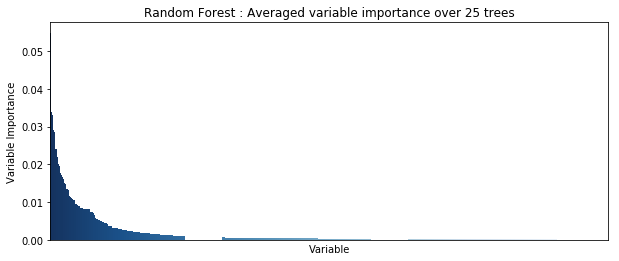

In [7]:
varPlot(X=X,model=model0,plotSize=(10,4),xticks=True)

In [8]:
model_vars0 = pd.DataFrame(
         {'variable':X.columns,
          'importance':model0.feature_importances_})

model_vars0.sort_values(by='importance',
                           ascending=False,
                           inplace=True)

In [9]:
n = 25

cols_model = [col for col in model_vars0.variable[:n].values]

In [10]:
oobAccuracy = {}

for cols in range(n):
    X = train[[col for col in model_vars0['variable'][:cols+1].values]]
    Y = train.activity
    
    model1 = rfc(n_estimators=ntree,
                 random_state=randomState,
                 n_jobs=4,
                 warm_start=False,
                 oob_score=True)
    
    model1 = model1.fit(X, Y)
    accuracy = accuracy_score(Y,model1.predict(X))
    
    oobAccuracy[cols+1] = [cols+1,model1.oob_score_,accuracy]

accuracyTable =pd.DataFrame.from_dict(oobAccuracy).transpose()
accuracyTable.columns = ['variables','oobAccuracy','accuracy']

Text(0.5,1,'OOB Accuracy vs Number of variables')

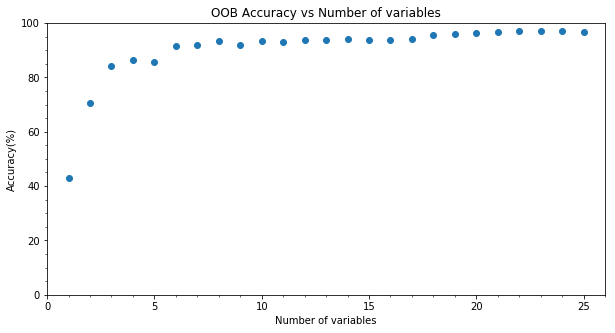

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(x=accuracyTable.variables,
                y=100*accuracyTable.oobAccuracy)

plt.xlim(0,n+1)
plt.ylim(0,100)
plt.minorticks_on()

plt.xlabel('Number of variables')
plt.ylabel('Accuracy(%)')
plt.title('OOB Accuracy vs Number of variables')

Text(0.5,1,'Random Forest : Averaged variable importance over 25 trees')

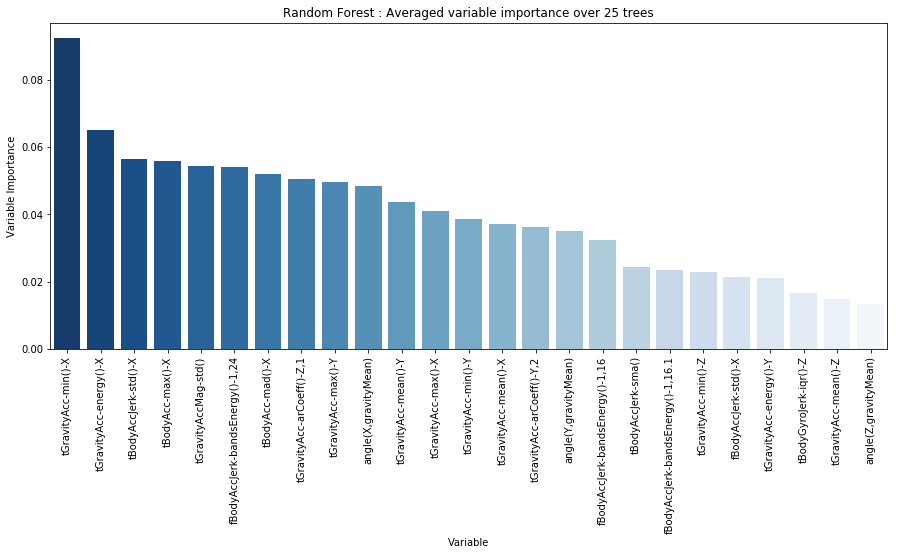

In [12]:
varPlot(X,model1)

In [13]:
n_used = 4

cols_model = [col for col in model_vars0.variable[:n_used].values] + [model_vars0.variable[6]]

In [14]:
X = train[cols_model]
Y = train.activity

In [15]:
ntree_determination = {}

for ntree in range(5,150,5):
    model = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
    model = model.fit(X, Y)
    ntree_determination[ntree]=model.oob_score_

/Users/am/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/am/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/am/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/am/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/am/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encounte

In [16]:
ntree_determination = pd.DataFrame.from_dict(ntree_determination,orient='index')
ntree_determination['ntree'] = ntree_determination.index
ntree_determination.columns=['oobScore','ntree']

Text(0,0.5,'OOB Accuracy')

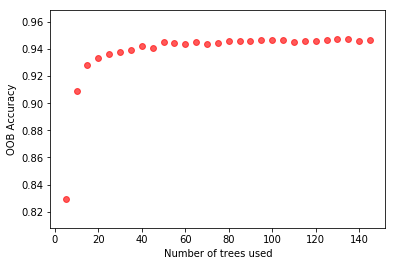

In [17]:
plt.figure(figsize=(6,4),)
plt.scatter(x='ntree',
                y='oobScore',
                s=35,c='red',alpha=0.65,
                data=ntree_determination)
plt.xlabel('Number of trees used')
plt.ylabel('OOB Accuracy')

In [18]:
model2 = rfc(n_estimators=50,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
model2 = model2.fit(X, Y)

Text(0.5,1,'Random Forest : Averaged variable importance over 145 trees')

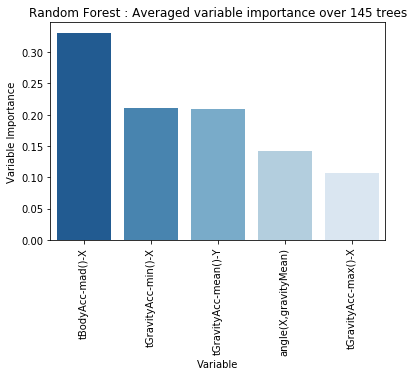

In [19]:
varPlot(X,model2,plotSize=(6,4))

In [20]:
train_actual = Y
train_pred = model2.predict(X)

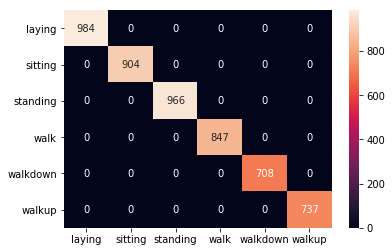

In [21]:
cm= confusion_matrix(train_actual,train_pred)
sns.heatmap(data=cm,
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(train_actual),
            yticklabels=np.unique(train_actual))

In [22]:
accuracy_score(train_actual,train_pred)

1.0

In [23]:
model2.oob_score_

0.9450058297706957

In [24]:
test_actual = test.activity
test_pred = model2.predict(test[X.columns])

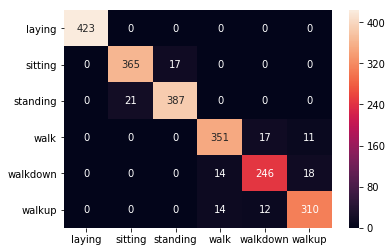

In [25]:
cm = confusion_matrix(test_actual,test_pred)
sns.heatmap(data=cm,
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(test_actual),
            yticklabels=np.unique(test_actual))

In [26]:
accuracy_score(test_actual,test_pred)

0.9437896645512239

<Figure size 432x432 with 0 Axes>

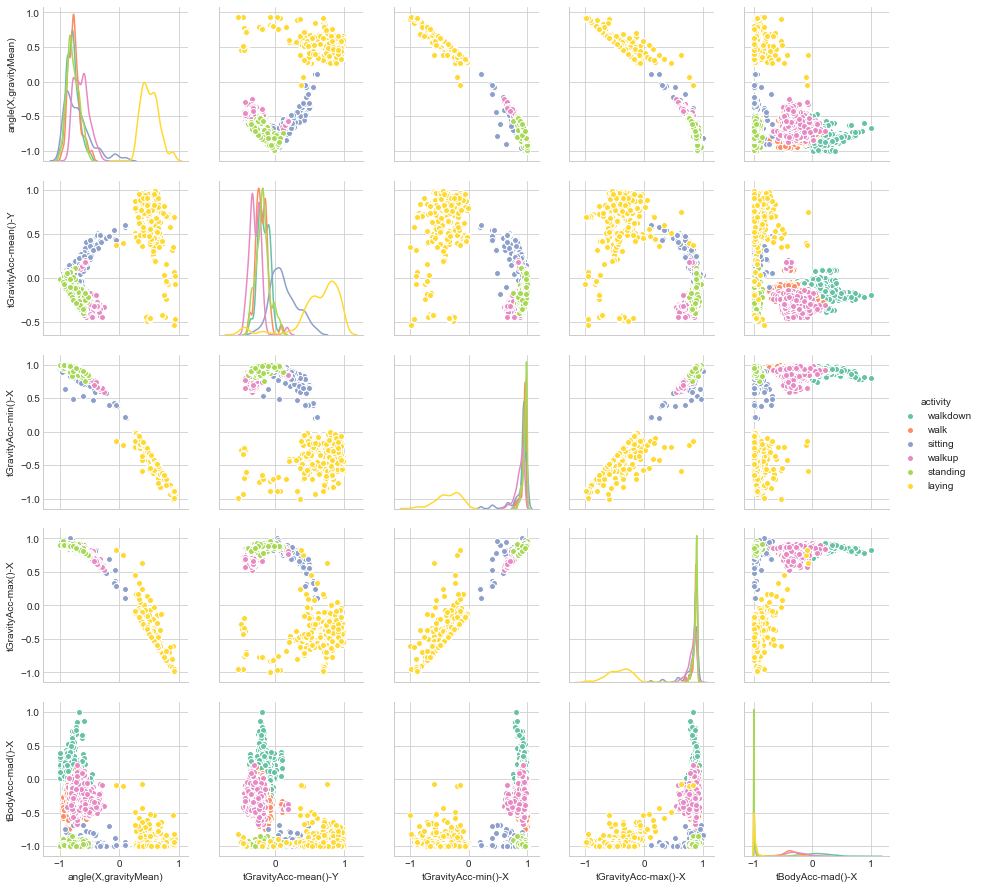

In [27]:
plt.figure(figsize=(6,6))
sns.set_style('whitegrid')

sns.pairplot(data=train[[col for col in X.columns]+['activity']],
             hue='activity',
             palette='Set2',
             diag_kind='kde')